<a href="https://colab.research.google.com/github/datle2403/datle2403/blob/main/Titanic_Input_layer_keras_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd

In [5]:
df=pd.read_csv('train.csv')

delete_col=['PassengerId','Name','Ticket']
categorical_col=['Pclass','Sex','SibSp','Parch','Cabin','Embarked']
bucktized_col=['Age']
Numeric_col=['Fare']
missing_col=['Age','Cabin','Embarked']

# for Embarked
df=df.drop(delete_col,axis=1)
df=df.dropna(subset=['Embarked'])

# for age and Cabin
from sklearn.impute import SimpleImputer
si= SimpleImputer(missing_values=np.nan, strategy='mean')
df['Age']=si.fit_transform(df['Age'].values.reshape(-1,1))
si2= SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')
df['Cabin']=si2.fit_transform(df['Cabin'].values.reshape(-1,1))


from sklearn.model_selection import train_test_split
df_train, df_test=train_test_split(df,train_size=0.9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Cabin     889 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


In [9]:
def df_to_dataset(df, shuffle=False, batch_size=32):
  df=df.copy()
  label=df.pop('Survived')
  #df={key: value[:,tf.newaxis] for key,value in df.items()}
  dataset= tf.data.Dataset.from_tensor_slices((dict(df), label))
  if shuffle:
    dataset.shuffle(len(df))
  return dataset.batch(batch_size).prefetch(batch_size)

In [10]:
train= df_to_dataset(df_train, shuffle=True, batch_size=20)
test= df_to_dataset(df_train, batch_size=20)

In [11]:
list(train.take(1))

[({'Pclass': <tf.Tensor: shape=(20,), dtype=int64, numpy=array([3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3])>,
   'Sex': <tf.Tensor: shape=(20,), dtype=string, numpy=
   array([b'male', b'female', b'male', b'male', b'male', b'male', b'female',
          b'male', b'male', b'male', b'male', b'female', b'male', b'male',
          b'male', b'male', b'male', b'male', b'male', b'male'], dtype=object)>,
   'Age': <tf.Tensor: shape=(20,), dtype=float64, numpy=
   array([21.       , 36.       , 36.       , 25.       , 20.       ,
           1.       , 17.       , 29.6420927, 19.       ,  1.       ,
          29.6420927, 29.       , 24.       , 29.6420927, 25.       ,
          28.       , 26.       , 26.       , 25.       , 35.       ])>,
   'SibSp': <tf.Tensor: shape=(20,), dtype=int64, numpy=array([0, 0, 0, 1, 0, 4, 4, 0, 1, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])>,
   'Parch': <tf.Tensor: shape=(20,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 4, 0, 0, 0, 1, 0, 0, 0

In [51]:
def get_normalization_layer(name, ds):
  normalizer= layers.Normalization(axis=None)

  feature_ds= ds.map(lambda x,y: x[name])

  normalizer.adapt(feature_ds)
  return normalizer
def get_categorical_layer(name,ds,dtype,max_token=None):
  if dtype == 'string':
    categorical= layers.StringLookup(max_tokens=max_token)
  else:
    categorical= layers.IntegerLookup(max_tokens=max_token)
  feature_ds= ds.map(lambda x,y: x[name])
  categorical.adapt(feature_ds)

  encoder= layers.CategoryEncoding(num_tokens=categorical.vocabulary_size())
  return lambda feature: encoder(categorical(feature))

cate_int=['Age','SibSp','Parch','Pclass']
cate_string=['Sex','Cabin', 'Embarked']
normalized=['Fare']
#Do_nothing=['Age']
# i will left Age col for do nothing

encode_feature=[]
all_inputs=[]
for x in cate_int:

  input_layer= layers.Input(shape=(1,),name=x, dtype='int64')
  encoder=get_categorical_layer(name=x, ds=train, dtype='int64')
  v= encoder(input_layer)
  encode_feature.append(v)
  all_inputs.append(input_layer)
for x in cate_string:

  input_layer= layers.Input(shape=(1,),name=x, dtype='string')
  encoder=get_categorical_layer(name=x, ds=train, dtype='string')
  v= encoder(input_layer)
  encode_feature.append(v)
  all_inputs.append(input_layer)
for x in normalized:

  input_layer= tf.keras.Input(shape=(1,), name=x)
  encoder=get_normalization_layer(name=x, ds=train)
  v= encoder(input_layer)
  encode_feature.append(v)
  all_inputs.append(input_layer)

# age_input= tf.keras.Input(shape=(1,), name='Age',dtype='float32')
# encode_feature.append(age_input)
# all_inputs.append(age_input)

In [52]:
encode_feature

[<KerasTensor: shape=(None, 72) dtype=float32 (created by layer 'category_encoding_47')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'category_encoding_48')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'category_encoding_49')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_50')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_51')>,
 <KerasTensor: shape=(None, 138) dtype=float32 (created by layer 'category_encoding_52')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_53')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_7')>]

In [53]:
all_feature= tf.keras.layers.concatenate(encode_feature)

In [54]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Age')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'SibSp')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Parch')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Pclass')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sex')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Cabin')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Embarked')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fare')>]

In [55]:
x = tf.keras.layers.Dense(32, activation="relu")(all_feature)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

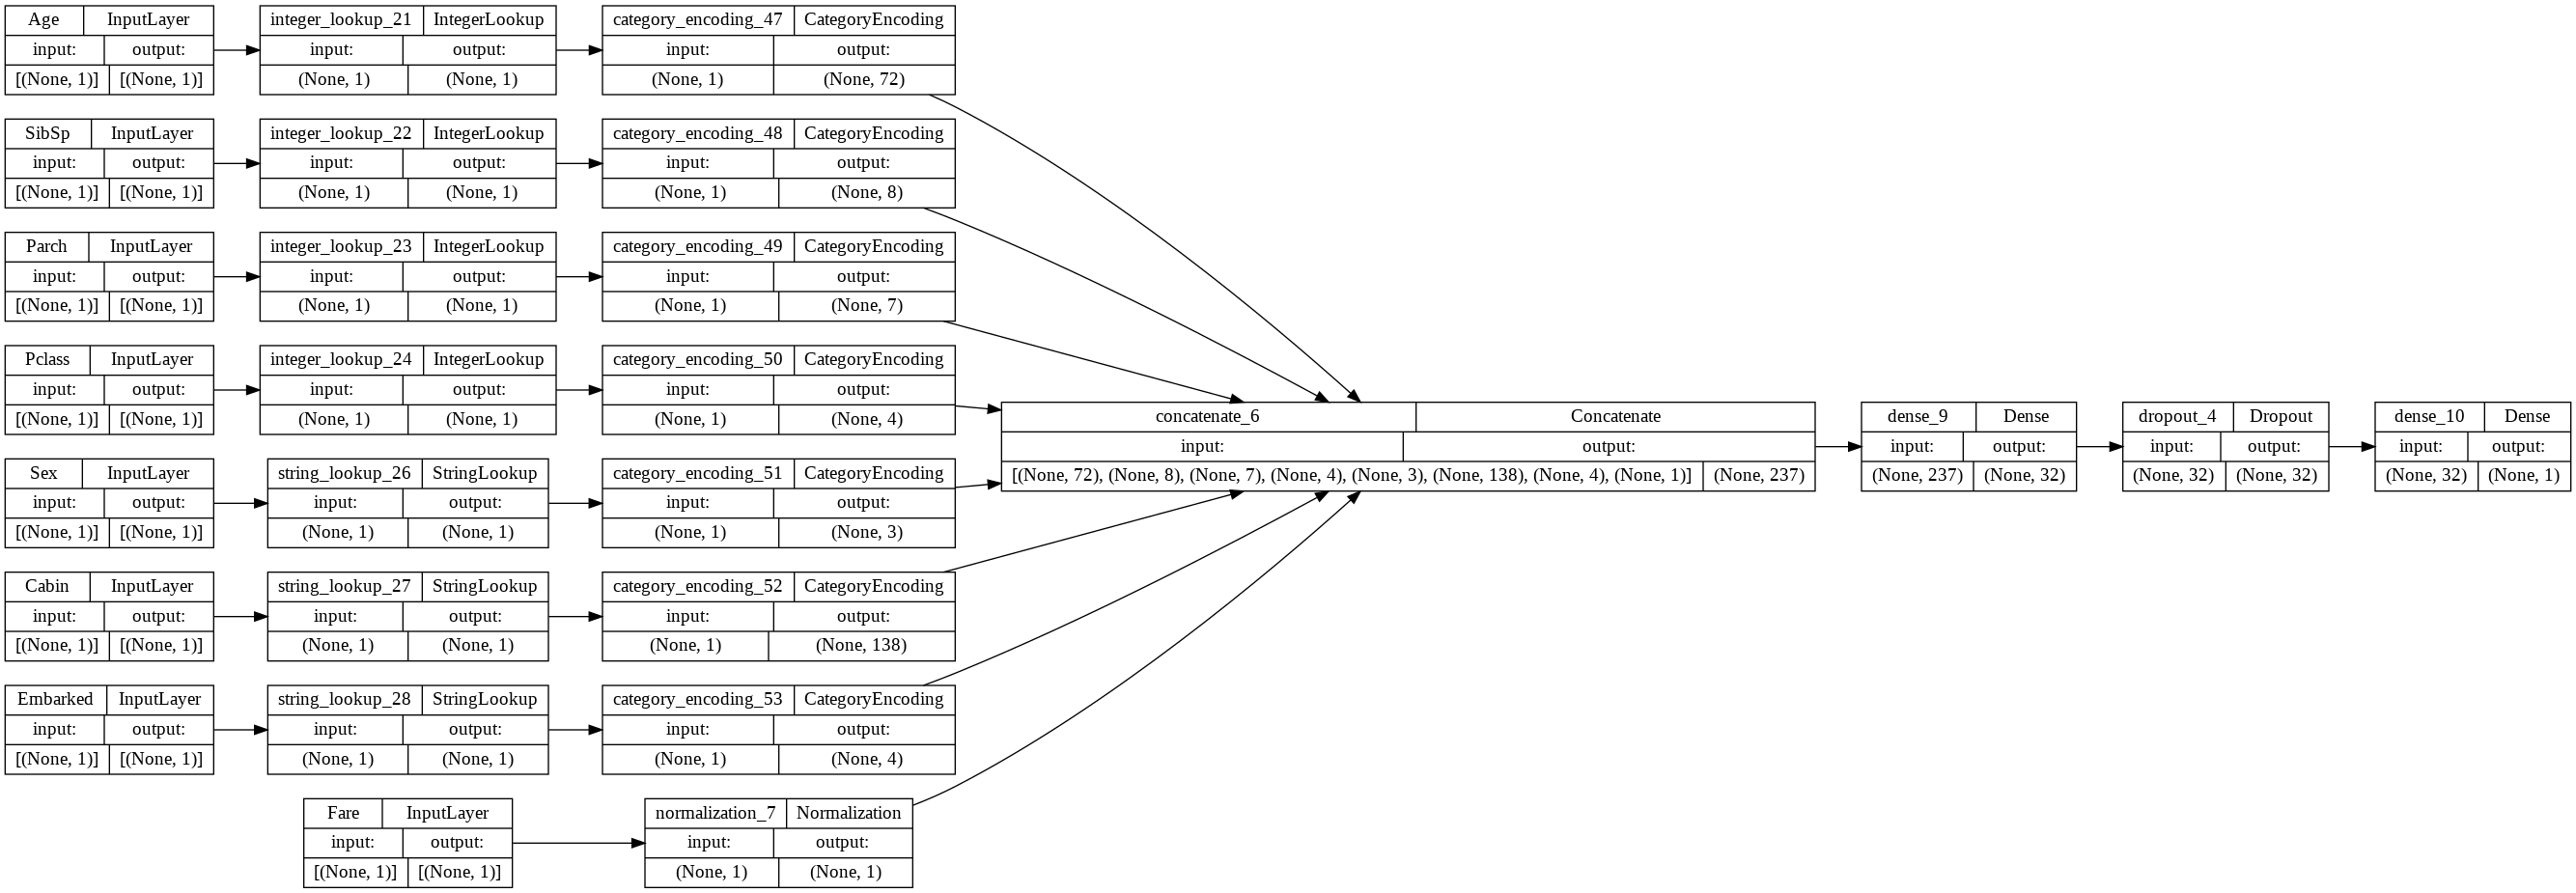

In [57]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [58]:
model.fit(train, epochs=100, validation_data=test)

Epoch 1/100
40/40 [==============================] - 2s 16ms/step - loss: 0.6559 - accuracy: 0.6313 - val_loss: 0.6060 - val_accuracy: 0.6325
Epoch 2/100
40/40 [==============================] - 0s 7ms/step - loss: 0.5958 - accuracy: 0.6550 - val_loss: 0.5618 - val_accuracy: 0.6562
Epoch 3/100
40/40 [==============================] - 0s 7ms/step - loss: 0.5644 - accuracy: 0.6850 - val_loss: 0.5277 - val_accuracy: 0.6988
Epoch 4/100
40/40 [==============================] - 0s 5ms/step - loss: 0.5324 - accuracy: 0.7013 - val_loss: 0.4983 - val_accuracy: 0.7287
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5012 - accuracy: 0.7387 - val_loss: 0.4742 - val_accuracy: 0.7613
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 0.4865 - accuracy: 0.7638 - val_loss: 0.4561 - val_accuracy: 0.7812
Epoch 7/100
40/40 [==============================] - 0s 6ms/step - loss: 0.4742 - accuracy: 0.7688 - val_loss: 0.4416 - val_accuracy: 0.8025
Epoch 8/100
